# Human Activity Recognition with Smartphones - Multi Class Classification

***

## Contents
1. [Overview](#1)
2. [Classification by Activity](#2)
3. [Classification by Subject](#3)
4. [Conclusion](#4)

***

<a id = '1'></a>
## 1. Overview
This notebook is a continuation of [this](https://github.com/wenhao7/Data-Science/blob/main/Human%20Activity%20Recognition%20with%20Smartphones/Human%20Activity%20Recognition%20with%20Smartphones%20-%20Analysis.ipynb) data analysis, where we will train classification models to identify the activities and subjects found in the dataset.

***

<a id = '2'></a>
## 2. Classification by Activity
Classification by activity will be done in two different ways.

Firstly, we will take the train and test sets provided from the data source as is. The train and test datasets do not have overlapping subjects simulating a scenario where models that have been trained on a separate group of people are used to identify the activities on an entirely new group of people.

Alternatively, we will combine the train and test csv before splitting the dataset by randomly sampling it into a train test split. This will simulate a scenario where the machine have previously obtained some measurements from a group of people, and with a fresh set of measurements from the same group of people the machine has to predict the activities.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

scaler = StandardScaler()

logreg = LogisticRegression()
svc = LinearSVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
lgbm = LGBMClassifier()

models = [logreg, svc, dtc, rfc, lgbm]

# Scenario 1, unique groups of subjects in train and test data
X_train = train.drop(['subject','Activity'], axis = 1)
y_train = train.Activity

X_test = test.drop(['subject','Activity'], axis = 1)
y_test = test.Activity

LogisticRegression()
Accuracy:  0.9535120461486257
Weighted f1:  0.9534351022023478


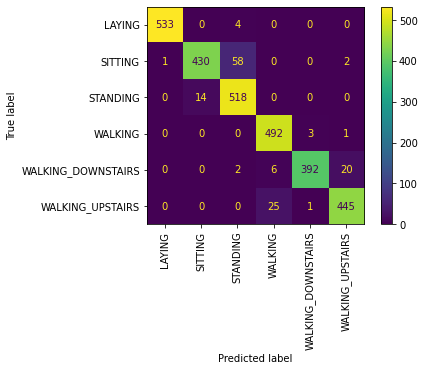

LinearSVC()
Accuracy:  0.9643705463182898
Weighted f1:  0.9641973066818874


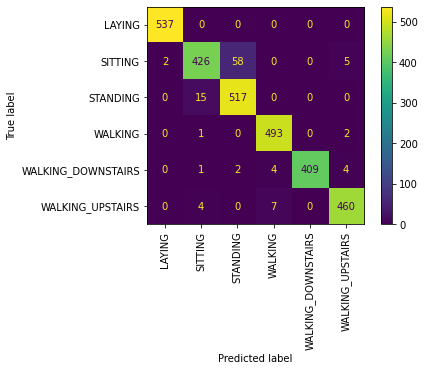

DecisionTreeClassifier()
Accuracy:  0.8489989820156091
Weighted f1:  0.8484935738188214


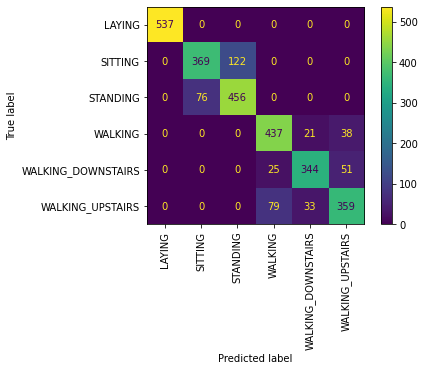

RandomForestClassifier()
Accuracy:  0.9229725144214456
Weighted f1:  0.9225272281754413


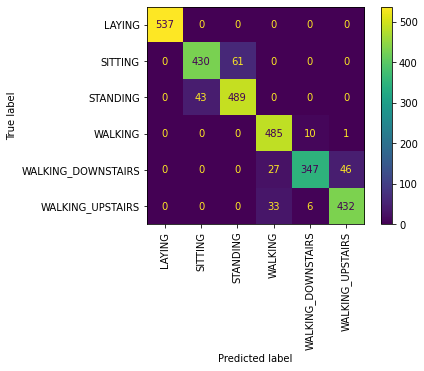

LGBMClassifier()
Accuracy:  0.9294197488971836
Weighted f1:  0.9291910122706316


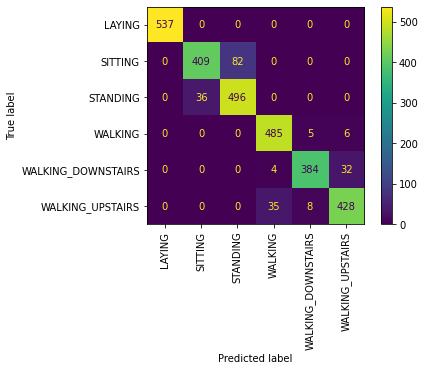

In [3]:
### Classify by Activities
for clf in models:
    pipe = Pipeline([('scaler', scaler), (str(clf), clf)])
    pipe.fit(X_train, y_train)
    
    pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print(str(clf))
    print('Accuracy: ', accuracy_score(y_test, pred))
    print('Weighted f1: ', f1_score(y_test, pred, average = 'weighted'))
    disp = ConfusionMatrixDisplay(cm, clf.classes_)
    disp.plot(xticks_rotation = 'vertical')
    plt.show()

From Scenario 1 (No overlapping subjects) we see that all classifiers except decision trees have accuracies and f1 scores above 90%, the best performer being LinearSVC with accuracy of 96.43%. Among the incorrect predictions across all classifiers, "SITTING" and "STANDING" makes up a majority of the misclassifications. This aligns with the conclusions drawn from the TSNE plots where "SITTING" and "STANDING" clusters were observed to be overlapping.

Except LinearSVC, all other classifiers tested misclassifiers some of the dynamic activities as well, typicalling misclassifying samples with true labels of "WALKING_DOWNSTAIRS" and "WALKING_UPSTAIRS".

In [4]:
# Scenario 2, overlapping subjects in train and test
df = pd.concat([train, test], axis = 0)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Activity', 'subject'], axis = 1), df.Activity, random_state = 33)

LogisticRegression()
Accuracy:  0.9825242718446602
Weighted f1:  0.9825157946828457


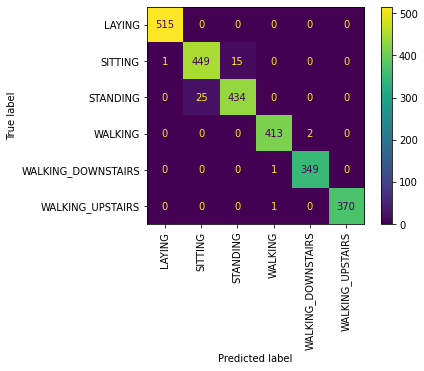

LinearSVC()
Accuracy:  0.982135922330097
Weighted f1:  0.9821823091961308


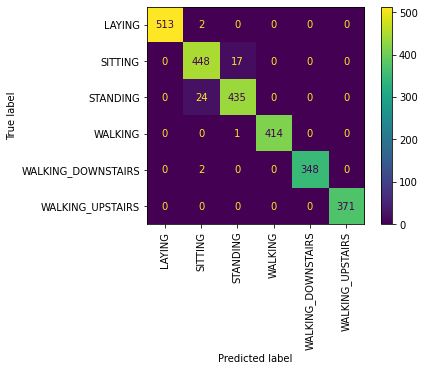

DecisionTreeClassifier()
Accuracy:  0.926990291262136
Weighted f1:  0.9270643918892895


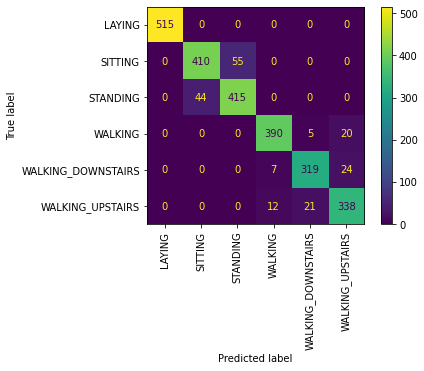

RandomForestClassifier()
Accuracy:  0.9763106796116505
Weighted f1:  0.976312747074891


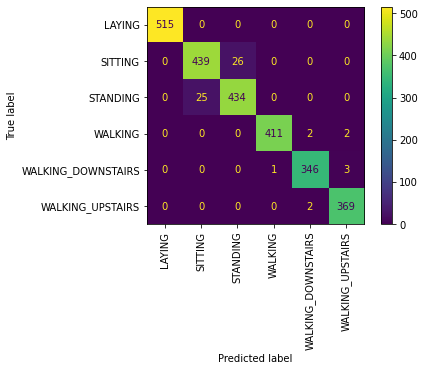

LGBMClassifier()
Accuracy:  0.9906796116504855
Weighted f1:  0.9906794769114359


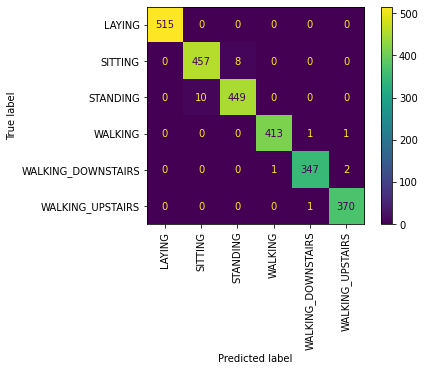

In [5]:
### Classify by Activities
for clf in models:
    pipe = Pipeline([('scaler', scaler), (str(clf), clf)])
    pipe.fit(X_train, y_train)
    
    pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print(str(clf))
    print('Accuracy: ', accuracy_score(y_test, pred))
    print('Weighted f1: ', f1_score(y_test, pred, average = 'weighted'))
    disp = ConfusionMatrixDisplay(cm, clf.classes_)
    disp.plot(xticks_rotation = 'vertical')
    plt.show()

From Scenario 2 (Overlapping subjects), we see significant improvements in model performance with all tested classifiers except decision trees  having accuracies and f1 scores above 97%. In this scenario, the best performers turns out to be LightGBM with an accuracy of 99.07%. Misclassifications in this scenario are almost entirely from "SITTING" and "STANDING" classes.

The results from these two scenarios suggests that with no prior knowledge of an individual (Scenario 1), we can already classify the activity to a high accuracy of approximately 96%. However, with some prioer knowledge of an individual (Scenario 2) we can classify the activity to an accuracy of approximately 99%. 

The best performing model (LGBM) exhibited some difficulties in differentiating dynamic activities clearly in Scenario 1, yet makes almost no mistakes in classifying dynamic activities in Scenario 2. This suggests that individuals may have their personal styles for each dynamic activities that may overlap with styles of other individuals for different dynamic activities. By including some samples from every subject for training, the model is taught to recognise the indivudal styles that each of the subjects have for each activity.

Number of features from gyroscope : 213
Number of features from accelerometer : 345


<AxesSubplot:>

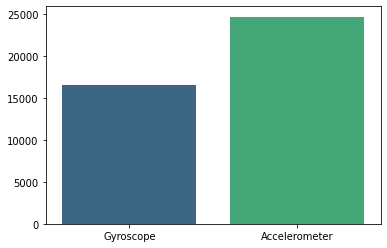

In [12]:
# Get importances
features = df.drop(['Activity', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
data2 = {'Gyro': 0, 'Acc':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
        data2['Gyro'] += 1
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        data2['Acc'] += 1

print('Number of features from gyroscope :', data2['Gyro'])
print('Number of features from accelerometer :', data2['Acc'])
sns.barplot(list(data.keys()), [data[k] for k in list(data.keys())], palette = 'viridis')        

When looking at feature importances we see that both sensors provide a significant portion of the information we have, with accelerometer providing approximately 50% more compared to the gyroscope.

*** 

<a id = '3'></a>
## 3. Classifying by Subject

In [13]:
### Classify by subjects
activities = df.Activity.unique().tolist()
for i in activities:
    df_subject = df.loc[df.Activity == str(i)]
    X_train, X_test, y_train, y_test = train_test_split(df_subject.drop(['Activity', 'subject'], axis = 1), df_subject.subject, random_state = 33)
    
    pipe = Pipeline([('scaler', scaler), ('lgbm', lgbm)])
    pipe.fit(X_train, y_train)
    
    pred = pipe.predict(X_test)
    print(str(i))
    print('Accuracy: ', accuracy_score(y_test, pred))
    print('Weighted f1: ', f1_score(y_test, pred, average = 'weighted'))

STANDING
Accuracy:  0.8805031446540881
Weighted f1:  0.8807507625413373
SITTING
Accuracy:  0.8134831460674158
Weighted f1:  0.8114058962378419
LAYING
Accuracy:  0.9320987654320988
Weighted f1:  0.93256248269545
WALKING
Accuracy:  0.9907192575406032
Weighted f1:  0.9907199049969386
WALKING_DOWNSTAIRS
Accuracy:  0.9545454545454546
Weighted f1:  0.9529450262231318
WALKING_UPSTAIRS
Accuracy:  0.9818652849740933
Weighted f1:  0.9819214881125667


When classifying by subjects we use the dataset from Scenario 2 (Overlapping subjects). Training LGBM models for each of the activity to classify subjects we obtained the results displayed above. From the results we see that in general measurements from static activities are less unique than the measuremetns from dynamic activities. 

Among the static activities subjects are correctly classified 88.05%, 81.35%, and 93.21% of the time during "STANDING", "SITTING", and "LAYING" respectively. The relatively lower accuracy in identifying individuals may be attributed to the experimental nature of the data collection process where the subjects may be stiffer in their motions or restricted to certain positions for consistency. During personal use most people are usually inclined to assume a position that they are most familiar/comfortable with, which may lead to easier identification from the sensors measurements.

Among the dynamic activities subjects are correctly classified 99.07%, 95.45%, and 98.19% of the time during "WALKING", "WALKIN_DOWNSTAIRS", and "WALKING_UPSTAIRS" respectively. This is consistent with what was observed from the TSNE plots where dynamic activities are clearly separable except for some overlaps in clusters when subjects are walking down stairs.

***

<a id = '6'></a>
## 4. Conclusion
In this notebook we have train models to classify activities and subjects from the smartphone dataset, exploring different scenarios and their effects on the predictive performances of models. The analysis from the previous notebook and results shown in this book have shown the potential that just ~1minute of data collected from the accelerometer and gyroscope can have. Even with the small amount of data collected per subject, the model is able to correctly predict the activity and even identify the individual up to 99% of the time. 

This demonstrates the potential of positive quality of life changes or even abusement of an individual privacy considering how long most people carry their gadgets around. Extensive options can be further opened up by linking to personal data of an individual or even to other sensors found on the same device.